In [ ]:
# Need to install transformers and datasets each time starting Colab

#!pip install transformers
#!pip install datasets

In [ ]:
import pandas as pd
import io
import numpy as np
import time
import random
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from datasets import load_dataset
from datasets import load_metric
from datasets import Dataset, DatasetDict

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

from sklearn.metrics import precision_recall_fscore_support, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


## Formatting Atis Data for HuggingFace
- Clean Airline Travel Information System Dataset can be found on Kaggle at: https://www.kaggle.com/siddhadev/atis-dataset-clean/home

In [ ]:
# Read in ATIS data
at_tr_full = pd.read_csv('/drive/My Drive/W266 - NLP with Deep Learning/Data/ATIS_Clean/atis.train.csv')
at_d = pd.read_csv('/drive/My Drive/W266 - NLP with Deep Learning/Data/ATIS_Clean/atis.dev.csv')
at_test = pd.read_csv('/drive/My Drive/W266 - NLP with Deep Learning/Data/ATIS_Clean/atis.dev.csv')

print("Train Dim:", at_tr_full.shape)
print("Dev Dim:", at_d.shape)
print("Test Dim:", at_test.shape)

at_tr_full.head()

Train Dim: (4274, 4)
Dev Dim: (572, 4)
Test Dim: (572, 4)


,id,tokens,slots,intent
0,train-00001,BOS what is the cost of a round trip flight fr...,O O O O O O O B-round_trip I-round_trip O O B-...,atis_airfare
1,train-00002,BOS now i need a flight leaving fort worth and...,O O O O O O O B-fromloc.city_name I-fromloc.ci...,atis_flight
2,train-00003,BOS i need to fly from kansas city to chicago ...,O O O O O O B-fromloc.city_name I-fromloc.city...,atis_flight
3,train-00004,BOS what is the meaning of meal code s EOS,O O O O O O B-meal_code I-meal_code I-meal_code O,atis_abbreviation
4,train-00005,BOS show me all flights from denver to pittsbu...,O O O O O O B-fromloc.city_name O B-toloc.city...,atis_flight


In [ ]:
# map actual labels (strings) to integers to work in model
print("All Intent Labels:")
print(at_tr_full['intent'].unique())

All Intent Labels:
['atis_airfare' 'atis_flight' 'atis_abbreviation' 'atis_ground_service'
 'atis_restriction' 'atis_airport' 'atis_quantity' 'atis_meal'
 'atis_airline' 'atis_city' 'atis_flight_no' 'atis_ground_fare'
 'atis_flight_time' 'atis_flight#atis_airfare' 'atis_distance'
 'atis_aircraft' 'atis_capacity']


In [ ]:
# create dict of integers mapped to intent labels
map_dict = {}
for i in range(len(at_tr_full['intent'].unique())):
  map_dict[at_tr_full['intent'].unique()[i]] = i

# map onto train and test data
at_tr_full['label'] = at_tr_full['intent'].map(map_dict)
at_test['label'] = at_test['intent'].map(map_dict) 

map_dict

{'atis_abbreviation': 2,
 'atis_aircraft': 15,
 'atis_airfare': 0,
 'atis_airline': 8,
 'atis_airport': 5,
 'atis_capacity': 16,
 'atis_city': 9,
 'atis_distance': 14,
 'atis_flight': 1,
 'atis_flight#atis_airfare': 13,
 'atis_flight_no': 10,
 'atis_flight_time': 12,
 'atis_ground_fare': 11,
 'atis_ground_service': 3,
 'atis_meal': 7,
 'atis_quantity': 6,
 'atis_restriction': 4}

In [ ]:
# format data to convert to a huggingface compatible dataset
at_tr_full['tokens'] = at_tr_full['tokens'].str.replace("BOS ", "")
at_tr_full['tokens'] = at_tr_full['tokens'].str.replace(" EOS", "")
at_tr_full.rename(columns={'tokens': 'text'}, inplace=True)

at_test['tokens'] = at_test['tokens'].str.replace("BOS ", "")
at_test['tokens'] = at_test['tokens'].str.replace(" EOS", "")
at_test.rename(columns={'tokens': 'text'}, inplace=True)

In [ ]:
# Create DatasetDict of train and test data
train_raw = Dataset.from_pandas(at_tr_full[['text', 'label']])
test_raw = Dataset.from_pandas(at_test[['text', 'label']])

raw_atis = DatasetDict({'train_raw': train_raw, 'test_raw': test_raw})

raw_atis

DatasetDict({
    train_raw: Dataset({
        features: ['text', 'label'],
        num_rows: 4274
    })
    test_raw: Dataset({
        features: ['text', 'label'],
        num_rows: 572
    })
})

In [ ]:
# Size of full training dataset
len(raw_atis['train_raw'])

4274

### Brief EDA
- Examples of texts to be classified
- Distribution of text lengths in data
- Classification category counts and baseline most frequent class calculation

In [ ]:
# Let's look at 5 random examples of text to be classified and their corresponding classification
idx_sample = random.sample(range(len(raw_atis['train_raw'])), 5)
text_samples = raw_atis['train_raw'].select(idx_sample)

for row in text_samples:
  print("Text:", row['text'])
  # use map_dict created earlier to see category
  print("Class:", list(map_dict.keys())[list(map_dict.values()).index(int(row['label']))])
  print()

Text: find travel arrangements for a round trip flight from dallas to pittsburgh after 8 pm
Class: atis_flight

Text: what type of aircraft are used on flights from cleveland to dallas that leave before noon
Class: atis_aircraft

Text: thank you very much now can you help me with information on flights from boston to atlanta
Class: atis_flight

Text: i'd like a flight on american from newark to nashville
Class: atis_flight

Text: show me all flights from san francisco to pittsburgh on a monday
Class: atis_flight



Avg. Text Length: 11.31118390266729



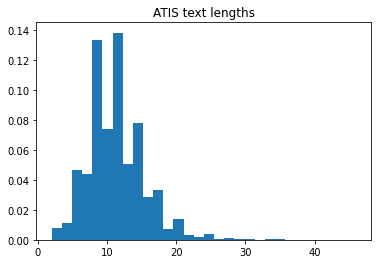

In [ ]:
# get list of text lengths in dataset
len_text = [len(x['text'].split()) for x in raw_atis['train_raw']]

print("Avg. Text Length:", np.mean(len_text))

plt.hist(len_text, density=True, bins=30) 
plt.title("ATIS text lengths")
print()
plt.show()

In [ ]:
# value counts for categories (we can use ATIS df to get this simply)
at_tr_full['intent'].value_counts()

atis_flight                 3173
atis_airfare                 351
atis_ground_service          207
atis_airline                 139
atis_abbreviation             94
atis_aircraft                 70
atis_quantity                 41
atis_flight_time              38
atis_capacity                 29
atis_distance                 24
atis_airport                  23
atis_flight#atis_airfare      21
atis_ground_fare              18
atis_city                     18
atis_flight_no                16
atis_meal                      9
atis_restriction               3
Name: intent, dtype: int64

In [ ]:
# Most common classifier calculation
print("Most common class frequency:", at_tr_full['intent'].value_counts()[0] / len(raw_atis['train_raw']))

Most common class frequency: 0.742395882077679


### Tokenize Data for DistilBert

In [ ]:
# define tokenizer function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# tokenize
tokenized_datasets = raw_atis.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets

DatasetDict({
    train_raw: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 4274
    })
    test_raw: Dataset({
        features: ['attention_mask', 'input_ids', 'label', 'text', 'token_type_ids'],
        num_rows: 572
    })
})

In [ ]:
# take a look at a tokenized input
print(tokenized_datasets['train_raw']['input_ids'][2])

[101, 1045, 2342, 2000, 4875, 2013, 5111, 2103, 2000, 3190, 2975, 2279, 9317, 1998, 4192, 1996, 2206, 2154, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Fine-tune and Evaluate DistilBert Models on ATIS

In [ ]:
dataset_name = 'ATIS'
training_sizes = [100, 200, 500, 1000, 2000, 3000, 4274]
n_dataset = 4274

results_list = []
for t_size in training_sizes:
    print("Training with size:", str(t_size))
    # get random subset of training data of t_size 
    idx_sample = random.sample(range(n_dataset), t_size)
    small_dataset = tokenized_datasets['train_raw'].select(idx_sample)

    # Fine-tune model
    #################
    # instantiate model
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=17)

    # start with default training args
    training_args = TrainingArguments("test_trainer")
    # change epochs and learning rate
    training_args.num_train_epochs = 4.0
    training_args.learning_rate = 2e-5

    # instantiate trainer
    trainer = Trainer(
        model=model, args=training_args, train_dataset=small_dataset, eval_dataset=tokenized_datasets['test_raw']
    )

    # start timer
    start_time = time.time()

    # fine-tune/train model
    trainer.train()

    # compute training time
    end_time = time.time()
    training_time = round(end_time-start_time)

    # Compute Metrics for Train and Test
    ####################################
    # define compute_metrics
    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        precision, recall, f1, _ = precision_recall_fscore_support( labels, predictions, average='weighted')
        acc = accuracy_score(labels, predictions)
        return {
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }
    
    # create trainer to evaluate training loss metric on small_dataset
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_dataset,
        eval_dataset=small_dataset,
        compute_metrics=compute_metrics,
    )

    # get training loss
    train_metrics = trainer.evaluate()
    train_loss = train_metrics['eval_loss']

    # create trainer to evaluate on test data
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=small_dataset,
        eval_dataset=tokenized_datasets['test_raw'],
        compute_metrics=compute_metrics,
    )
    
    # Compile and write results to file
    ###################################
    # create results dict of evaluation on test data and training info
    results = trainer.evaluate()
    results['dataset'] = dataset_name
    results['training_time'] = training_time
    results['training_loss'] = train_loss
    results['training_size'] = t_size

    # append results_list and write to csv at each iteration
    results_list.append(results)
    results_df = pd.DataFrame(results_list)
    results_df.to_csv('/drive/My Drive/W266 - NLP with Deep Learning/Data/ATIS_results.csv', index = False)

Training with size: 100


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_1

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 100
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with size: 200


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_1

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 200
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with size: 500


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_1

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 500
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with size: 1000


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_1

Step,Training Loss
500,0.489700


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with size: 2000


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_1

Step,Training Loss
500,0.521200
1000,0.129200


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with size: 3000


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_1

Step,Training Loss
500,0.503700
1000,0.116300
1500,0.058800


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training with size: 4274


loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_1

Step,Training Loss
500,0.507900
1000,0.116300
1500,0.055500
2000,0.026900


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine-tune BERT base on full training data and evaluate 

In [ ]:
# tokenize the data
# define tokenizer function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# tokenize
tokenized_datasets = raw_atis.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
# initial model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=17)

# set training args
training_args = TrainingArguments("test_trainer")
training_args.num_train_epochs = 4.0
training_args.learning_rate = 2e-5

# instantiate trainer
trainer = Trainer(
    model=model, args=training_args, train_dataset=tokenized_datasets['train_raw'], eval_dataset=tokenized_datasets['test_raw']
)

# train model
trainer.train()

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Step,Training Loss
500,0.491800
1000,0.111100
1500,0.059000
2000,0.041600


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_trainer/checkpoint-2000/config.json
Model weights saved in test_trainer/checkpoint-2000/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=2140, training_loss=0.1654078947049435, metrics={'train_runtime': 3023.7121, 'train_samples_per_second': 5.654, 'train_steps_per_second': 0.708, 'total_flos': 4498752408084480.0, 'train_loss': 0.1654078947049435, 'epoch': 4.0})

In [ ]:
# evaluate accuracy on test data
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train_raw'],
    eval_dataset=tokenized_datasets['test_raw'],
    compute_metrics=compute_metrics,
)
trainer.evaluate()

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 572
  Batch size = 8


{'eval_accuracy': 0.9877622377622378,
 'eval_loss': 0.07300890237092972,
 'eval_runtime': 36.951,
 'eval_samples_per_second': 15.48,
 'eval_steps_per_second': 1.949}